1) Setup (instalación y comprobación)

In [24]:
%pip install -q scikit-learn matplotlib joblib

# Comprobación rápida
import sklearn, matplotlib
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

Note: you may need to restart the kernel to use updated packages.
sklearn: 1.3.1
matplotlib: 3.8.0


In [26]:
import sklearn, matplotlib
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)


sklearn: 1.3.1
matplotlib: 3.8.0


2) Carga de datos (Parquet del ETL) y arranque Spark


In [28]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .master("local[*]")       # puedes cambiar a "spark://spark-master:7077" si quieres usar el cluster
         .appName("model-baseline")
         .getOrCreate())

DATA_PATH = "/data/processed/employee_attrition.parquet"
df_spark = spark.read.parquet(DATA_PATH)

df_spark.printSchema()
df_spark.limit(5).toPandas()
df_spark.count()

root
 |-- EmployeeNumber: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string (nullable = true)
 |-- PercentSalaryHike:

1470

3) Preparación para ML (Pandas, target y columnas)

In [30]:
import numpy as np
import pandas as pd

# Pasamos a pandas para usar scikit-learn
pdf = df_spark.toPandas()

# Variable objetivo
y = pdf["attrition_label"].astype(int)

# Columnas que retiramos (ID, constantes o duplicadas de la label)
drop_cols = [
    "attrition_label", "Attrition", "EmployeeNumber",
    "EmployeeCount", "StandardHours", "Over18"  # suelen ser constantes en este dataset
]
X = pdf.drop(columns=[c for c in drop_cols if c in pdf.columns], errors="ignore")

# Detectamos tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Shape X:", X.shape, " | num:", len(num_cols), " | cat:", len(cat_cols))
(cat_cols[:10], num_cols[:10])

Shape X: (1470, 38)  | num: 31  | cat: 7


(['BusinessTravel',
  'Department',
  'EducationField',
  'Gender',
  'JobRole',
  'MaritalStatus',
  'OverTime'],
 ['Age',
  'DailyRate',
  'DistanceFromHome',
  'Education',
  'EnvironmentSatisfaction',
  'HourlyRate',
  'JobInvolvement',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome'])

4) Split, preprocesado y modelos (LogReg + RandomForest)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Split estratificado por desbalanceo (~16% positivo)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Preprocesado:
# - num: StandardScaler (with_mean=False para evitar problemas cuando se concatena con OHE -> matriz esparsa)
# - cat: OneHotEncoder ignorando categorías no vistas en train
preproc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

# Modelos baseline
pipe_lr = Pipeline(steps=[
    ("prep", preproc),
    ("clf", LogisticRegression(
        solver="liblinear",   # estable y rápido en binario
        penalty="l2",
        C=1.0,
        max_iter=1000,
        class_weight="balanced"
    ))
])


pipe_rf = Pipeline(steps=[
    ("prep", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=400, n_jobs=-1, random_state=42,
        class_weight="balanced_subsample"
    ))
])


5) Validación cruzada (CV) estratificada

In [34]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_cv = cross_val_score(pipe_lr, X, y, cv=cv, scoring="roc_auc")
f1_cv  = cross_val_score(pipe_lr, X, y, cv=cv, scoring="f1")

print("LogReg CV — AUC: %.3f ± %.3f" % (auc_cv.mean(), auc_cv.std()))
print("LogReg CV —  F1: %.3f ± %.3f" % (f1_cv.mean(),  f1_cv.std()))


LogReg CV — AUC: 0.817 ± 0.025
LogReg CV —  F1: 0.479 ± 0.015


6) Entrenamiento y métricas clave (accuracy, F1, ROC-AUC)

In [36]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

models = {"logreg": pipe_lr, "rf": pipe_rf}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    metrics = {
        "accuracy": float(accuracy_score(y_test, pred)),
        "f1":       float(f1_score(y_test, pred)),
        "roc_auc":  float(roc_auc_score(y_test, proba)),
    }
    results[name] = metrics

results


{'logreg': {'accuracy': 0.7619047619047619,
  'f1': 0.4444444444444444,
  'roc_auc': 0.7933499870789904},
 'rf': {'accuracy': 0.8469387755102041,
  'f1': 0.1818181818181818,
  'roc_auc': 0.8030407442501508}}

6.1) Asegurar best_model

In [38]:
# Elegir el mejor por ROC-AUC en test 
best_name = max(results.items(), key=lambda kv: kv[1]["roc_auc"])[0]
best_model = models[best_name]
best_name


'rf'

6.2) Calcular el umbral óptimo por F1

In [40]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

proba = best_model.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, proba)

f1s = [f1_score(y_test, (proba >= t).astype(int)) for t in thr]
best_idx = int(np.argmax(f1s))
best_thr = float(thr[best_idx])
best_f1  = float(f1s[best_idx])

print(f"Mejor umbral por F1: {best_thr:.3f} | F1={best_f1:.3f} | modelo={best_name}")


Mejor umbral por F1: 0.233 | F1=0.523 | modelo=rf


6.3) Guardar umbral y modelo juntos

In [42]:
import os, json, joblib

os.makedirs("/output/metrics", exist_ok=True)
with open("/output/metrics/threshold_tuning.json","w") as f:
    json.dump({
        "model": best_name,
        "best_threshold_by_f1": best_thr,
        "best_f1": best_f1
    }, f, indent=2)

os.makedirs("/output/models", exist_ok=True)
model_path = f"/output/models/{best_name}_baseline.pkl"
joblib.dump({"model": best_model, "threshold": best_thr}, model_path)

print("Guardado:")
print(" - /output/metrics/threshold_tuning.json")
print(" -", model_path)


Guardado:
 - /output/metrics/threshold_tuning.json
 - /output/models/rf_baseline.pkl


In [44]:
from sklearn.metrics import average_precision_score

proba_best = best_model.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, proba_best)
print(f"PR-AUC (best): {pr_auc:.3f}")

PR-AUC (best): 0.462


7) Matriz de confusión y curvas ROC

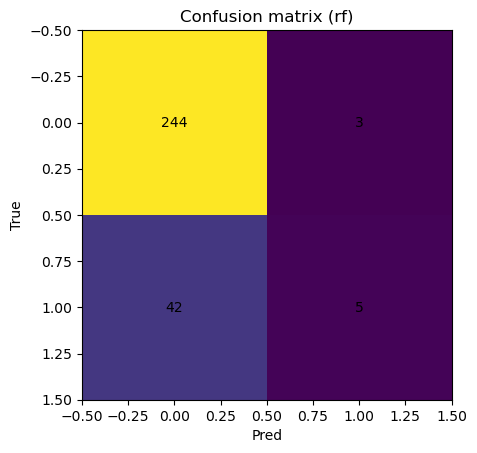

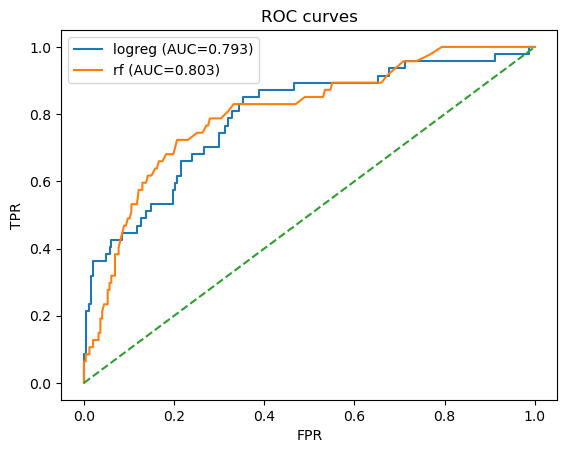

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Elegimos el mejor por AUC
best_name = max(results.items(), key=lambda kv: kv[1]["roc_auc"])[0]
best_model = models[best_name]

# Confusión
proba_best = best_model.predict_proba(X_test)[:,1]
pred_best = (proba_best >= 0.5).astype(int)
cm = confusion_matrix(y_test, pred_best)

plt.figure()
plt.imshow(cm)
plt.title(f"Confusion matrix ({best_name})"); plt.xlabel("Pred"); plt.ylabel("True")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.show()

# ROC de ambos modelos
plt.figure()
for name, model in models.items():
    p = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,p):.3f})")
plt.plot([0,1],[0,1],"--")
plt.title("ROC curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.show()


8) Guardar métricas y modelo ganador

In [48]:
import os, json, joblib

os.makedirs("/output/metrics", exist_ok=True)
with open("/output/metrics/model_baseline.json","w") as f:
    json.dump(results, f, indent=2)

os.makedirs("/output/models", exist_ok=True)
model_path = f"/output/models/{best_name}_baseline.pkl"
joblib.dump(best_model, model_path)

print("Resultados guardados en:")
print(" - /output/metrics/model_baseline.json")
print(" -", model_path)


Resultados guardados en:
 - /output/metrics/model_baseline.json
 - /output/models/rf_baseline.pkl


9) Importancias (Random Forest) + nombres de features (incluye OHE) y export a CSV

In [50]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def get_feature_names(preproc, num_cols, cat_cols):
    """Devuelve la lista de nombres de features tras ColumnTransformer (num + OHE)."""
    feat_names = []

    # Numéricas: se mantienen los nombres
    feat_names.extend(num_cols)

    # Categóricas: usar get_feature_names_out del OHE ya ajustado
    # Acceso al transformer OneHot ya "fitted"
    # Nota: en sklearn >=1.0: get_feature_names_out
    ohe = preproc.named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    feat_names.extend(cat_feature_names.tolist())
    return feat_names

# Solo tiene sentido si el best es RF (importancias)
if best_name == "rf":
    pre = best_model.named_steps["prep"]
    clf = best_model.named_steps["clf"]

    feature_names = get_feature_names(pre, num_cols, cat_cols)
    importances = clf.feature_importances_

    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False)

    os.makedirs("/output/metrics", exist_ok=True)
    fi.to_csv("/output/metrics/feature_importance_rf.csv", index=False)
    fi.head(20)
else:
    print("El mejor modelo no es RandomForest; importancias no disponibles.")


10) Ajuste de umbral para mejor F1/recall

In [52]:
from sklearn.metrics import precision_recall_curve, f1_score

proba = best_model.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, proba)

# Elegir el umbral que maximiza F1
f1_vals = [f1_score(y_test, (proba >= t).astype(int)) for t in thr]
best_idx = int(np.argmax(f1_vals))
best_thr = float(thr[best_idx])
best_f1 = float(f1_vals[best_idx])

print(f"Mejor umbral por F1: {best_thr:.3f} | F1={best_f1:.3f}")

# Guarda el mejor umbral
with open("/output/metrics/threshold_tuning.json","w") as f:
    json.dump({"best_threshold_by_f1": best_thr, "best_f1": best_f1}, f, indent=2)


Mejor umbral por F1: 0.233 | F1=0.523


11) Resumen de métricas y guardado

In [54]:
import json, os, pandas as pd

# Carga lo ya guardado
with open("/output/metrics/model_baseline.json") as f:
    model_metrics = json.load(f)

thr_meta = {}
try:
    with open("/output/metrics/threshold_tuning.json") as f:
        thr_meta = json.load(f)
except FileNotFoundError:
    pass

# Tabla de KPIs
rows = []
for name, m in model_metrics.items():
    rows.append({
        "model": name,
        "accuracy": m.get("accuracy"),
        "f1": m.get("f1"),
        "roc_auc": m.get("roc_auc"),
    })
kpis = pd.DataFrame(rows).sort_values("roc_auc", ascending=False)
display(kpis)

os.makedirs("/output/metrics", exist_ok=True)
kpis.to_csv("/output/metrics/kpis_modelos.csv", index=False)
print("KPIs guardados en /output/metrics/kpis_modelos.csv")

# Añade umbral ganador si existe
if thr_meta:
    print("Best threshold bundle:", thr_meta)


,model,accuracy,f1,roc_auc
1,rf,0.846939,0.181818,0.803041
0,logreg,0.761905,0.444444,0.793350


KPIs guardados en /output/metrics/kpis_modelos.csv
Best threshold bundle: {'best_threshold_by_f1': 0.2325, 'best_f1': 0.5233644859813084}


12) Gráficas para informe

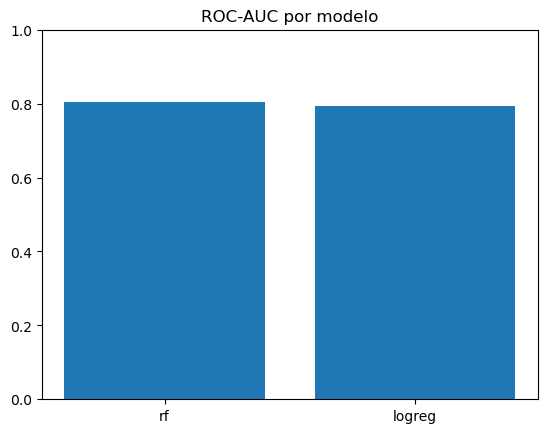

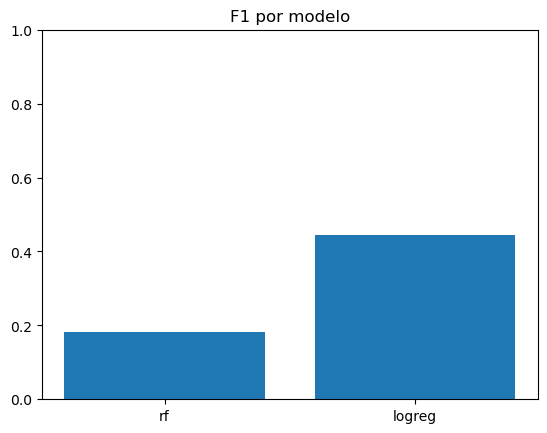

Plot guardado en /output/plots/*.png


In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Barra de AUC y F1
fig, ax = plt.subplots()
ax.bar(kpis["model"], kpis["roc_auc"])
ax.set_title("ROC-AUC por modelo")
ax.set_ylim(0, 1.0)
os.makedirs("/output/plots", exist_ok=True)
plt.savefig("/output/plots/roc_auc_por_modelo.png")
plt.show()

fig, ax = plt.subplots()
ax.bar(kpis["model"], kpis["f1"])
ax.set_title("F1 por modelo")
ax.set_ylim(0, 1.0)
plt.savefig("/output/plots/f1_por_modelo.png")
plt.show()

print("Plot guardado en /output/plots/*.png")
